# Data Loading and Exploration

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import warnings
import os
import sys
import contextlib

In [5]:
data = pd.read_csv('data/obesity.csv')
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
data.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [7]:
# Identify numerical and categorical columns
num_features = data.select_dtypes(include=['int64', 'float64']).columns
cat_features = data.select_dtypes(exclude=['int64', 'float64']).columns

In [8]:
data[cat_features].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
NObeyesdad                        7
dtype: int64

Seems to be an ordering to NObeyesdad and CAEC/CALC

In [9]:
print(data['NObeyesdad'].value_counts())
print(data['CAEC'].value_counts())
print(data['CALC'].value_counts())
print(data['MTRANS'].value_counts())

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          286
Insufficient_Weight    272
Name: count, dtype: int64
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64
MTRANS
Public_Transportation    1578
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64


After looking at the metadata, this is confirmed so we can move forward with encoding.

In [10]:
data_clean = data.copy()
data_clean['NObeyesdad'] = data_clean['NObeyesdad'].map({'Insufficient_Weight': -1, 'Normal_Weight': 0, 'Overweight_Level_I': 1, 'Overweight_Level_II': 2, 'Obesity_Type_I': 3, 'Obesity_Type_II': 4, 'Obesity_Type_III': 5})
data_clean['CAEC'] = data_clean['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data_clean['CALC'] = data_clean['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data_clean.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,1,no,2.0,no,0.0,1.0,0,Public_Transportation,0.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1,yes,3.0,yes,3.0,0.0,1,Public_Transportation,0.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,1,no,2.0,no,2.0,1.0,2,Public_Transportation,0.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,1,no,2.0,no,2.0,0.0,2,Walking,1.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,1,no,2.0,no,0.0,0.0,1,Public_Transportation,2.0


In [11]:
data_clean = pd.get_dummies(data_clean, drop_first=True, dtype=int)
data_clean.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,1,2.0,0.0,1.0,0,0.0,0,1,0,0,0,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,1,3.0,3.0,0.0,1,0.0,0,1,0,1,1,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,1,2.0,2.0,1.0,2,0.0,1,1,0,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,1,2.0,2.0,0.0,2,1.0,1,0,0,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,1,2.0,0.0,0.0,1,2.0,1,0,0,0,0,0,0,1,0


In [12]:
# rename columns to get rid of _yes (it's obvious)
data_clean.columns = data_clean.columns.str.replace('_yes', '')
data_clean.describe()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,2111.000000,2111.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.567110,2.469702,2.685479,1.140692,2.030749,1.010777,0.657866,0.731407,2.113270,0.505921,0.817148,0.883941,0.020843,0.045476,0.003316,0.005211,0.747513,0.026528
std,6.345968,0.093305,26.237871,2.380357,0.778193,0.468543,1.211104,0.850509,0.608927,0.515498,1.984999,0.500083,0.386637,0.320371,0.142893,0.208395,0.057502,0.072015,0.434542,0.160737
min,14.000000,1.450000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658689,1.000000,1.584812,0.127654,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.777890,1.700499,83.000000,2.387426,3.000000,1.000000,2.000000,1.000000,0.625350,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,26.000000,1.768464,107.430682,3.000000,3.000000,1.000000,2.479558,1.666821,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,61.000000,1.980000,173.000000,109.000000,4.000000,3.000000,50.000000,3.000000,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Appears to be only one missing value and so it will be dropped

In [13]:
data_clean[data_clean['NCP'].isna()]

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
115,17.0,1.75,57.0,3.0,NaN,2,2.0,NaN,1.0,0,0.0,0,0,1,0,0,0,0,0,0


In [14]:
data_clean.dropna(inplace=True)
data_clean.corr()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
Age,1.000000,-0.025825,0.202043,0.022692,-0.043587,-0.082963,-0.029812,-0.145711,-0.297300,0.043964,0.282197,0.048280,0.205471,0.064279,0.091895,-0.116548,0.003599,0.020228,-0.554256,-0.063251
Height,-0.025825,1.000000,0.464112,-0.029364,0.243679,-0.049362,0.097600,0.295124,0.051623,0.130246,0.133739,0.619223,0.247526,0.178360,0.055517,-0.133749,0.029004,-0.010466,-0.089756,0.036969
Weight,0.202043,0.464112,1.000000,0.018209,0.109249,-0.287784,0.096745,-0.051164,-0.071655,0.205547,0.912706,0.162047,0.497771,0.272001,0.025690,-0.201668,-0.021724,-0.037260,0.059346,-0.100694
FCVC,0.022692,-0.029364,0.018209,1.000000,0.042835,0.051134,0.003925,-0.000117,-0.045866,-0.016387,0.017727,-0.082955,0.018883,0.001589,0.000108,0.011474,-0.007921,-0.003225,0.025340,-0.000374
NCP,-0.043587,0.243679,0.109249,0.042835,1.000000,0.097595,0.036495,0.129788,0.036441,0.071963,0.027115,0.067642,0.071771,-0.007140,0.007868,-0.015542,0.023336,0.003903,-0.057084,0.006566
CAEC,-0.082963,-0.049362,-0.287784,0.051134,0.097595,1.000000,-0.079070,0.031177,0.047981,-0.046295,-0.329022,-0.090641,-0.170828,-0.150464,0.055434,0.109430,0.017914,0.076699,-0.003438,0.082760
CH2O,-0.029812,0.097600,0.096745,0.003925,0.036495,-0.079070,1.000000,0.128607,0.047467,0.019600,0.066265,0.073217,0.083562,-0.046901,-0.018936,-0.000037,0.012144,-0.001840,-0.013400,0.117961
FAF,-0.145711,0.295124,-0.051164,-0.000117,0.129788,0.031177,0.128607,1.000000,0.058912,-0.087671,-0.200681,0.189196,-0.056502,-0.107832,0.011137,0.074123,0.067119,-0.016397,-0.048445,0.108870
TUE,-0.297300,0.051623,-0.071655,-0.045866,0.036441,0.047981,0.047467,0.058912,1.000000,-0.045260,-0.108350,0.018060,0.021765,0.068534,0.017584,-0.010986,-0.021747,-0.067444,0.143813,0.073391
CALC,0.043964,0.130246,0.205547,-0.016387,0.071963,-0.046295,0.019600,-0.087671,-0.045260,1.000000,0.151462,-0.008549,-0.035895,0.089728,0.082455,0.003372,-0.017939,-0.026159,0.024365,-0.017003


In [15]:
corr_matrix = data_clean.corr()

# Create a condensed correlation matrix
condensed_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().reset_index()
condensed_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Add a temporary column for sorting by absolute values
condensed_corr['AbsCorrelation'] = condensed_corr['Correlation'].abs()
condensed_corr_sorted = condensed_corr.sort_values('AbsCorrelation', ascending=False)
condensed_corr_sorted = condensed_corr_sorted.drop(columns=['AbsCorrelation'])

print(condensed_corr_sorted)

      Feature 1                       Feature 2  Correlation
44       Weight                      NObeyesdad     0.912706
28       Height                     Gender_Male     0.619223
17          Age    MTRANS_Public_Transportation    -0.554256
146  NObeyesdad  family_history_with_overweight     0.505153
46       Weight  family_history_with_overweight     0.497771
..          ...                             ...          ...
63         FCVC                            FAVC     0.001589
69         FCVC                  MTRANS_Walking    -0.000374
57         FCVC                             FAF    -0.000117
64         FCVC                           SMOKE     0.000108
107        CH2O                             SCC    -0.000037

[190 rows x 3 columns]


In [16]:
def plot_data(x, y, data):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, data=data)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

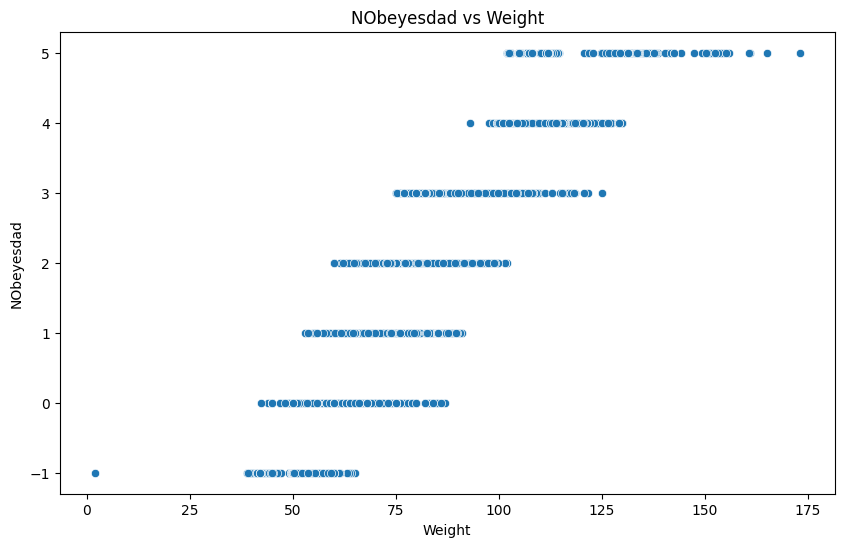

In [17]:
plot_data('Weight', 'NObeyesdad', data_clean)

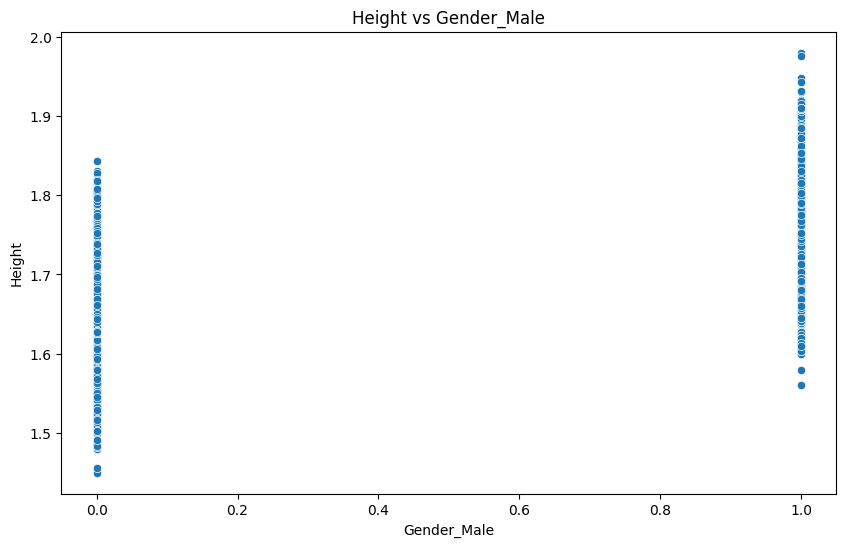

In [18]:
plot_data('Gender_Male', 'Height', data_clean)

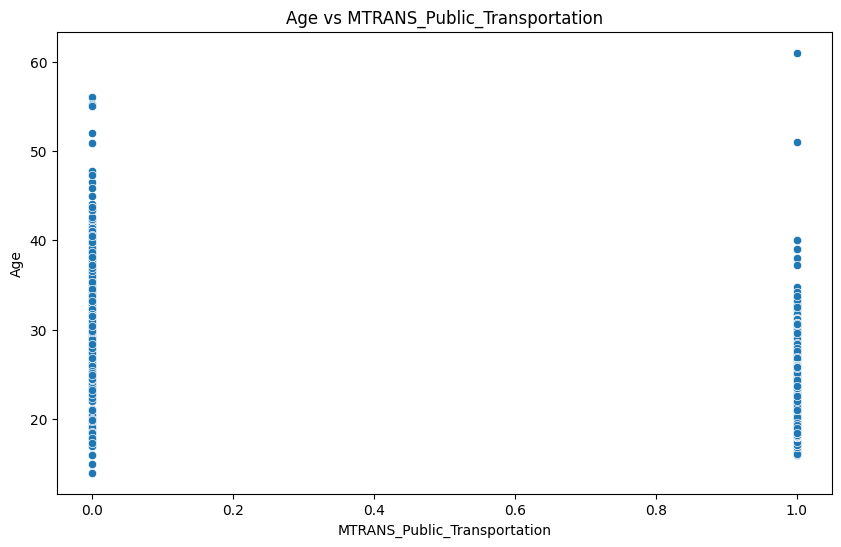

In [19]:
plot_data('MTRANS_Public_Transportation', 'Age', data_clean)

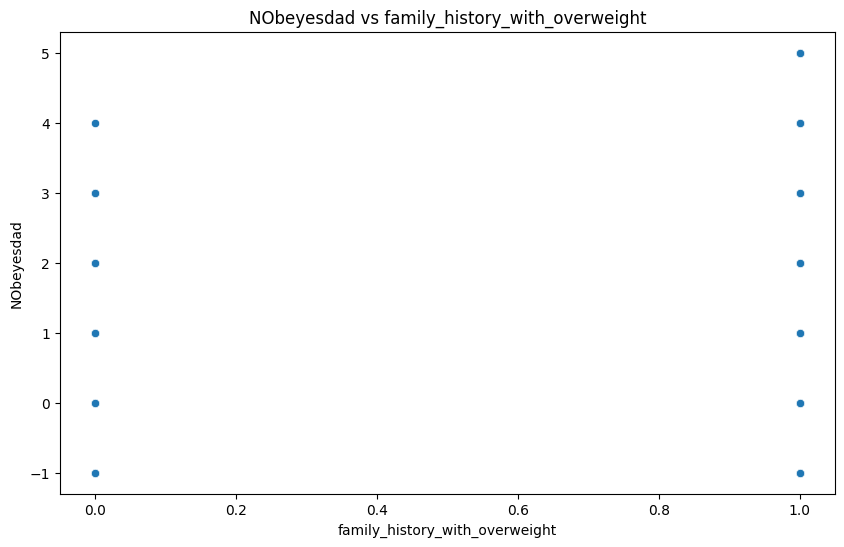

In [20]:
plot_data('family_history_with_overweight', 'NObeyesdad', data_clean)

In [21]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)

Start by evaluating on all the features

In [22]:
# Context manager to suppress stdout and stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [23]:
num_features

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

Scale numerical data

In [24]:
scaler = StandardScaler()
data_scaled = data_clean.copy()
data_scaled[num_features] = scaler.fit_transform(data_scaled[num_features], data_scaled['NObeyesdad'])
data_scaled.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.523072,-0.875169,-0.861124,-0.197269,0.404376,1,-0.025408,-1.188443,0.561682,0,0.0,0,1,0,0,0,0,0,1,0
1,-0.523072,-1.946769,-1.166083,0.222745,0.404376,1,0.800090,2.338855,-1.080738,1,0.0,0,1,0,1,1,0,0,1,0
2,-0.207834,1.053709,-0.365567,-0.197269,0.404376,1,-0.025408,1.163089,0.561682,2,0.0,1,1,0,0,0,0,0,1,0
3,0.422641,1.053709,0.015632,0.222745,0.404376,1,-0.025408,1.163089,-1.080738,2,1.0,1,0,0,0,0,0,0,0,1
4,-0.365453,0.839390,0.122367,-0.197269,-2.165781,1,-0.025408,-1.188443,-1.080738,1,2.0,1,0,0,0,0,0,0,1,0


# Supervised Learning Methods

## Best Models, Overview

In [25]:
X = data_scaled.drop(columns='NObeyesdad')
y = data_scaled['NObeyesdad'] # response is obesity level

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier()
}

# Evaluate models using cross-validation (5 folds)
for name, model in models.items():
    with suppress_stdout_stderr(), warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{name} CV Accuracy: {cv_scores.mean()}')

Logistic Regression CV Accuracy: 0.8710506467336853
KNN CV Accuracy: 0.849707872251804
LDA CV Accuracy: 0.876269545541534
SVM CV Accuracy: 0.9156263016289359
Decision Tree CV Accuracy: 0.9255642737332688
Naive Bayes CV Accuracy: 0.535797187918632
Neural Network CV Accuracy: 0.9194222737557836


Now going back to a simpler approach

## Logistic Regression

In [26]:
# Function to suppress stdout and stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def best_subset_selection(X, y):
    n = len(X.columns)
    results = []
    total_combinations = sum([len(list(itertools.combinations(X.columns, k))) for k in range(1, n + 1)])

    # Suppress specific warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    with tqdm(total=total_combinations) as pbar:
        for k in range(1, n + 1):
            for combo in itertools.combinations(X.columns, k):
                try:
                    X_train_subset = sm.add_constant(X[list(combo)])
                    with suppress_stdout_stderr(), np.errstate(all='ignore'):
                        model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                    aic = model.aic
                    results.append((aic, combo))
                except (np.linalg.LinAlgError, ValueError):
                    pass
                pbar.update(1)
    
    best_model = sorted(results, key=lambda x: x[0])[0]
    return best_model[1]

In [55]:
# Find the best subset of features
best_features = best_subset_selection(X, y)
print('Best subset of features:', best_features)

  0%|          | 1232/524287 [00:42<4:57:42, 29.28it/s]


KeyboardInterrupt: 

In [27]:
def hybrid_feature_selection(X, y, initial_features=[]):
    included = list(initial_features)
    best_score = float('inf')
    while True:
        changed = False
        
        # Forward step
        excluded = list(set(X.columns) - set(included))
        for new_feature in excluded:
            try_features = included + [new_feature]
            X_train_subset = sm.add_constant(X[try_features])
            try:
                with suppress_stdout_stderr(), warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                score = model.aic
                if score < best_score:
                    best_score = score
                    best_feature = new_feature
                    changed = True
            except (np.linalg.LinAlgError, ValueError):
                continue
        if changed:
            included.append(best_feature)
            print(f'Forward step: {included} (AIC: {best_score})')
        
        worst_feature = ''
        # Backward step
        for feature in included:
            try_features = list(set(included) - {feature})
            if not try_features:
                continue
            X_train_subset = sm.add_constant(X[try_features])
            try:
                with suppress_stdout_stderr(), warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                score = model.aic
                if score < best_score:
                    best_score = score
                    worst_feature = feature
                    changed = True
            except (np.linalg.LinAlgError, ValueError):
                continue
        if changed and len(worst_feature) > 0:
            included.remove(worst_feature)
            print(f'Backward step: {included} (AIC: {best_score})')
        
        if not changed:
            break

    return included

In [28]:
# Use the hybrid feature selection to find the best subset of features
hybrid_features = hybrid_feature_selection(X, y)
print('Best subset of features:', hybrid_features)

Forward step: ['Weight'] (AIC: 4240.91748704769)
Forward step: ['Weight', 'FCVC'] (AIC: 3819.1931846346033)
Forward step: ['Weight', 'FCVC', 'Age'] (AIC: 3609.1301194855555)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP'] (AIC: 3393.9895316683205)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF'] (AIC: 3169.6475907023387)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC'] (AIC: 3004.966821669967)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O'] (AIC: 2881.0796043541177)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC'] (AIC: 2782.3387923247064)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC'] (AIC: 2690.532744543125)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation'] (AIC: 2606.0540758674415)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_histo

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE'] (AIC: 2542.271640927891)


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE', 'MTRANS_Walking'] (AIC: 2530.3934838400364)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE', 'MTRANS_Walking', 'SCC'] (AIC: 2495.484384576628)


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Best subset of features: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE', 'MTRANS_Walking', 'SCC']


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Seems as though we're failing to get the optimal set of features, as the full model still out-performs the one fit on the 'best' subset.

In [29]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X[hybrid_features], y) # optimal subset of features
y_pred = log_reg.predict(X[hybrid_features])
print(classification_report(y, y_pred))

cv_score = cross_val_score(log_reg, X[hybrid_features], y, cv=5, scoring='accuracy')
print(f'CV Accuracy: {cv_score.mean()}')

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

        -1.0       0.80      0.92      0.85       272
         0.0       0.74      0.59      0.65       285
         1.0       0.70      0.73      0.71       290
         2.0       0.57      0.48      0.52       290
         3.0       0.68      0.70      0.69       351
         4.0       0.94      0.95      0.94       297
         5.0       0.91      1.00      0.95       324

    accuracy                           0.77      2109
   macro avg       0.76      0.77      0.76      2109
weighted avg       0.76      0.77      0.76      2109

CV Accuracy: 0.7349596424671566


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

## Decision Trees

In [31]:
dt = DecisionTreeClassifier(random_state=42, max_features=X.shape[1])

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_}')

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12960 fits failed out of a total of 51840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8760 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation accuracy: 0.9284213844266078


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.92651664 0.87437719 0.92604496 ... 0.29634812 0.32006844 0.29634812]
  warnings.warn(


In [ ]:
dt_best = grid_search.best_estimator_.fit(X, y)
y_pred = dt_best.predict(X)
print(classification_report(y, y_pred))
cv_score = cross_val_score(dt_best, X[hybrid_features], y, cv=5, scoring='accuracy')
print(f'CV Accuracy: {cv_score.mean()}')

## Neural Network

## SVM

# Unsupervised Learning Methods